# Jet tagging with Quantum Machine Learning @ LHCb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Dataset
The dataset is stored in two csv files produced using LHCb OpenData tuples that are publicly available

In [2]:
import pandas as pd
# Input variables of the quantum circuit
variables = ['idx','mu_Q', 'mu_pTrel','mu_dist',  # (anti-)muon
             'k_Q', 'k_pTrel','k_dist',     # (anti-)kaon
             'pi_Q', 'pi_pTrel','pi_dist',  # (anti-)pion
             'e_Q', 'e_pTrel','e_dist',     # (anti-)electron
             'p_Q', 'p_pTrel','p_dist',     # (anti-)proton
             'Jet_QTOT',                    # Weighted Jet Total Charge
             'Jet_LABEL']                   # Ground Truth label

# Events are split in two subsets for training and testing
trainData = pd.read_csv("data/trainData.csv")[variables]
testData = pd.read_csv("data/testData.csv")[variables]

In [3]:
trainData

,idx,mu_Q,mu_pTrel,mu_dist,k_Q,k_pTrel,k_dist,pi_Q,pi_pTrel,pi_dist,e_Q,e_pTrel,e_dist,p_Q,p_pTrel,p_dist,Jet_QTOT,Jet_LABEL
0,193050_bbdw50V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,890.095232,0.183681,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.074850,1
1,149852_bbdw50V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,626.426733,0.143763,1.0,46.453933,0.145099,0.0,0.000000,0.000000,0.265662,1
2,105744_bbdw20V2,0.0,0.000000,0.000000,-1.0,18.137164,0.005636,1.0,818.093614,0.397854,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.111038,0
3,210937_bbdw50V2,0.0,0.000000,0.000000,1.0,325.469288,0.325645,1.0,2225.300742,0.079475,-1.0,121.388362,0.451234,0.0,0.000000,0.000000,0.802690,1
4,200964_bbdw20V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-1.0,643.830874,0.247228,1.0,13.429954,0.022191,0.0,0.000000,0.000000,-0.337908,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442822,179252_bbup20V2,0.0,0.000000,0.000000,1.0,816.199330,0.431660,-1.0,238.314901,0.025363,1.0,1.422987,0.004671,-1.0,618.842862,0.162634,0.049430,1
442823,129589_bbdw50V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,874.153517,0.406933,-1.0,94.079730,0.129382,0.0,0.000000,0.000000,-0.051080,1
442824,186866_bbdw20V2,1.0,850.089781,0.159359,0.0,0.000000,0.000000,1.0,391.015117,0.234847,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.827509,1
442825,262204_bbup50V2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-1.0,627.943798,0.218008,0.0,0.000000,0.000000,1.0,349.426663,0.207633,0.187058,0


 ## Preprocessing
 The variables need to be preprocessed before the training process. Here we adopt a technique that suited well for our QML application: firstly data are normalized using a StandardScaler, then the arctan function is applied.

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(pd.concat([trainData,testData])[variables[1:-1]])
trainData[variables[1:-1]] = np.arctan(trainData[variables[1:-1]])
testData[variables[1:-1]] = np.arctan(testData[variables[1:-1]])

## QML Model
![Circuit](img/circuit.png)



In [5]:
import pennylane as qml

n_qubits = 4
n_layers = 4

# default.qubit.tf is a quantum simulator that uses Tensorflow as backend
# it supports back-propagation, which is useful with a large number of
# parameters

dev = qml.device("default.qubit.tf",wires=n_qubits) # Device initialization

# In pennylane, quantum circuits are mostly defined via the qnode decorator
# applied to a function which describes the quantum gates to be applied to 
# each qubit and, finally, the measurement to be performed.

@qml.qnode(dev, interface="tf", diff_method='backprop')
def circuit(inputs,weights):
    
# The AmplitudeEmbedding template implements the embedding of 2**N features
# in N qubits. Amplitudes must be < 0, so a normalization is performed. 
    qml.templates.AmplitudeEmbedding(inputs,wires=range(n_qubits),normalize=True)
    
# The StronglyEntanglingLayers templates implements a variable number of
# layers made of rotation around all the axes and CNOT gates. Rotation angles
# are passed via the weights parameter of dimension (n_layers,n_qubits,3)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(4))
    
# Finally, the expectation value of the Sigma_Z Pauli matrix of the first qubit
# is measured. It will range from -1 to 1 and will be mapped to a label prediction
    return qml.expval(qml.PauliZ(0))

2021-07-07 12:07:54.067317: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-07 12:07:54.067492: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-07 12:07:54.068687: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Keras model
A great feature of pennylane is that it can be integrated flawlessly inside Keras and PyTorch models. This allows for the developing of hybrid quantum-classical machine learning models. 

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation

# We generate the quantum Keras layer, specifiying the dimension of the
# trainable parameters and of the output of the layer.
quantum_layer = qml.qnn.keras.KerasLayer(circuit,weight_shapes={'weights':(n_layers,n_qubits,3)},output_dim=1)

# Finally, we build a Sequencial model appending a sigmoid function to
# the quantum layer
model = Sequential([quantum_layer,Activation('sigmoid')])

## Training

In [7]:
from tensorflow.keras.optimizers import Adam

# Let's pick an optimizer
opt = Adam(learning_rate=0.02)

# We choose the Mean Square Error as our loss function and a binary
# accuracy as our metric
model.compile(opt, loss="mse",metrics=['binary_accuracy']) 

# We fix the size of the training dataset and validation dataset
training_size   = 100
validation_size = 100

# And build a balanced training sample ...
bsample = trainData[trainData.Jet_LABEL == 0].sample(training_size//2)
bbarsample = trainData[trainData.Jet_LABEL == 1].sample(training_size//2)

training_sample = pd.concat([bsample,bbarsample]).sample(frac=1.0)

X = training_sample[variables[1:-1]]
Y = training_sample[variables[-1]]

# And validation sample
val_bsample = testData[testData.Jet_LABEL == 0].sample(validation_size//2)
val_bbarsample = testData[testData.Jet_LABEL == 1].sample(validation_size//2)

validation_sample = pd.concat([val_bsample,val_bbarsample]).sample(frac=1.0)

val_X = validation_sample[variables[1:-1]]
val_Y = validation_sample[variables[-1]]

# Finally, we start the training process
n_epochs = 10
history_fit = model.fit(X,Y,epochs=n_epochs,validation_data=(val_X,val_Y))

2021-07-07 12:07:59.371609: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-07 12:07:59.371896: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2999985000 Hz


Epoch 1/10
4/4 [==============================] - 10s 3s/step - loss: 0.2575 - binary_accuracy: 0.4844 - val_loss: 0.2424 - val_binary_accuracy: 0.6250
Epoch 2/10
4/4 [==============================] - 10s 3s/step - loss: 0.2536 - binary_accuracy: 0.4729 - val_loss: 0.2419 - val_binary_accuracy: 0.6172
Epoch 3/10
4/4 [==============================] - 9s 2s/step - loss: 0.2542 - binary_accuracy: 0.3990 - val_loss: 0.2428 - val_binary_accuracy: 0.6328
Epoch 4/10
4/4 [==============================] - 9s 2s/step - loss: 0.2516 - binary_accuracy: 0.5177 - val_loss: 0.2437 - val_binary_accuracy: 0.5781
Epoch 5/10
4/4 [==============================] - 9s 2s/step - loss: 0.2508 - binary_accuracy: 0.5385 - val_loss: 0.2443 - val_binary_accuracy: 0.5859
Epoch 6/10
4/4 [==============================] - 10s 3s/step - loss: 0.2440 - binary_accuracy: 0.5563 - val_loss: 0.2450 - val_binary_accuracy: 0.5859
Epoch 7/10
4/4 [==============================] - 10s 3s/step - loss: 0.2429 - binary_accur

## Training results

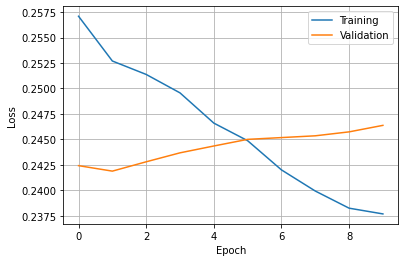

In [8]:
plt.plot(history_fit.history['loss'], label="Training")
plt.plot(history_fit.history['val_loss'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

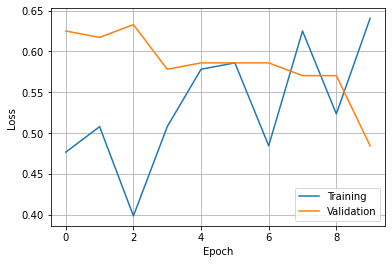

In [9]:
plt.plot(history_fit.history['binary_accuracy'], label="Training")
plt.plot(history_fit.history['val_binary_accuracy'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Testing

In [ ]:

# Let's also build a balanced testing sample
testing_size = 1000

test_bsample = testData[testData.Jet_LABEL == 0].sample(testing_size//2)
test_bbarsample = testData[testData.Jet_LABEL == 1].sample(testing_size//2)

testing_sample = pd.concat([test_bsample,test_bbarsample]).sample(frac=1.0)

test_X = testing_sample[variables[1:-1]]
test_Y = testing_sample[variables[-1]]

# And let's predict the label with our trained model
test_predY= model.predict(test_X)
testing_sample['RawPred'] = test_predY
testing_sample['Jet_PREDLABEL'] = np.round(test_predY)

## Testing results

### Prediction distribution

In [ ]:
plt.hist(testing_sample[testing_sample['Jet_LABEL'] == 0]['RawPred'],bins=100,alpha=0.7,label="b")
plt.hist(testing_sample[testing_sample['Jet_LABEL'] == 1]['RawPred'],bins=100,alpha=0.7,label="$\\bar{b}$")
plt.xlabel("RawPred")
plt.legend()
plt.plot()

## Receiver Operating Characteristic curve and Area Under Curve

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr,tpr, _ = roc_curve(testing_sample['Jet_LABEL'],testing_sample['RawPred'])
auc = roc_auc_score(testing_sample['Jet_LABEL'],testing_sample['RawPred'])

In [ ]:
plt.plot(fpr,tpr,label='QML')
plt.plot([0,1],[0,1], label='Random classifier')
plt.text(0.6,0.2,f"AUC = {auc:.2}",fontsize=20)
plt.legend()

## Saving predictions

In [ ]:
testing_sample

In [ ]:
# Finally, we can save our model prediction for future analysis (bbar asymmetry estimation,
# tagging performance analysis, ...)

testing_sample.to_csv("data_with_predictions.csv",index=False)